### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import general_functions as gf
from tqdm import tqdm
#from mpl_toolkits.axes_grid1 import make_axes_locatable

### Parameter values

In [5]:
# Parameter values
# State values
tau = 50
refractory_state = tau
resting_state = 0
excited_state = 2 * tau
# Dysfunctional values
dysfunctional_value = 1
not_dysfunctional_value = 0
# Connected to above or not
connected_above_value = 1
not_connected_above_value = 0
# Info  
info_state_idx = 0
info_dysfuntional_idx = 1
info_connected_above_idx = 2

### Functions

In [163]:
def initial_structure(L, nu, delta):
    """Cell info consists of three LxL matrices containing the following:
        State: resting, excited, refractory
        Dysfunctional or not
        Connected to above or not

    Args:
        L: int - length of cell sheet
        nu: float - probability for cell to be connected to the cell above it
        delta: float - probablity to be dysfunctional

    Returns:
        np.ndarray: Cell info containing three LxL matrices
    """
    
    cell_info = np.empty((L, L, 3))
    # States
    cell_info[:, :, info_state_idx] = resting_state
    cell_info[:, 0, info_state_idx] = excited_state  # Left boundary is pacemaker.
    # Dysfunctional
    cell_info[:, :, info_dysfuntional_idx] = np.random.choice(a=[dysfunctional_value, not_dysfunctional_value], p=[delta, 1-delta], replace=True, size=(L, L))
    # Connected to above
    cell_info[:, :, info_connected_above_idx] = np.random.choice(a=[connected_above_value, not_connected_above_value], p=[nu, 1-nu], replace=True, size=(L, L))
    return cell_info


def add_fibrosis(cell_info, nu_fibrosis, length_fibrosis_vec, pos_fibrosis_vec):
    """Change the vertical connections in a subregion of the system

    Args:
        cell_info (np.ndarray): (L, L, 3) array 
        nu_fibrosis (float): Probability to have a vertical connection in the subregion
        length_fibrosis_vec (tuple of ints): (Lx, Ly). Width and length of the subregion
        pos_fibrosis_vec (tuple of ints): Upper left corner of the subregion
    """
    L = np.shape(cell_info)[0]
    x, y = pos_fibrosis_vec
    # Get width of fibrosis. Cannot extend beyond boundaries.
    l_x, l_y = length_fibrosis_vec
    width_x = min(l_x + x, L - 1)
    width_y = min(l_y + y, L - 1)
    
    # Update values
    cell_info[x : width_x, y : width_y, info_connected_above_idx] = np.random.choice(a=[connected_above_value, not_connected_above_value], p=[nu_fibrosis, 1-nu_fibrosis], replace=True, size=(l_x, l_y))
    

def excite_nbors(target_idx, cell_info, epsilon):
    # Find and potentially excite neighbours
    L = np.shape(cell_info)[0]
    
    x = target_idx[0]
    y = target_idx[1]

    # Open boundary for horizontal direction
    # Periodic boundary for vertical direction    
    nbor_left = (x, max(y - 1, 0))
    nbor_right = (x, min(y + 1, L - 1))
    
    nbor_down = ((x + L + 1) % L, y)
    nbor_up = ((x + L - 1) % L, y)
    
    # Check if vertically connected. If not, set "neighbour" to be itself

    if cell_info[*nbor_up, info_connected_above_idx] == not_connected_above_value:
        nbor_up = (x, y)
    if cell_info[*target_idx, info_connected_above_idx] == not_connected_above_value:
        nbor_down = (x, y)

    # Excite neighbours which are in relaxed state.
    # Take dysfunctional cells into account
    for nbor_idx in [nbor_left, nbor_right, nbor_down, nbor_up]:
        nbor_state = cell_info[*nbor_idx, info_state_idx]
        nbor_dysfunctional = cell_info[*nbor_idx, info_dysfuntional_idx]
        if nbor_state == resting_state:
            nbor_state_value = excited_state
            
            random_number = np.random.uniform(low=0, high=1)
            did_not_work = random_number < epsilon
            if nbor_dysfunctional == dysfunctional_value and did_not_work:
                nbor_state_value = cell_info[*nbor_idx, info_state_idx]
                
            cell_info[*nbor_idx, info_state_idx] = nbor_state_value


def reduce_refractory(cell_info):
    # Get all refractory sites and reduce their value by 1
    refractory_idx = np.logical_and(cell_info[:, :, info_state_idx] > resting_state, cell_info[:, :, info_state_idx] <= refractory_state)
    cell_info[refractory_idx, info_state_idx] -= 1


def pacemaker_activation(t: int, cell_info: np.ndarray, T=220):
    """Every T time steps, activate the pacemaker (the leftmost column).

    Args:
        t (int): Current time
        cell_info (np.ndarray): Cell state and more
        T (int, optional): How often the pacemaker activates. Defaults to int.
    """
    if t % T == 0:
        # Get all cells in first row that is not dysfunctional
        # Do we need to take epsilon into account as well?
        idx_not_dysfunctional = np.where(cell_info[:, 0, info_dysfuntional_idx] == not_dysfunctional_value)
        cell_info[idx_not_dysfunctional, 0, info_state_idx] = excited_state  # Left boundary


def evolve(L: int, nu: float, delta: float, epsilon: float, tmax: int, cell_band_width=50, fibrosis_par={}) -> tuple:
    """AF heart simulation.

    Args:
        L (int): Length/Height of the 2d cell sheet
        nu (float): Probability of having a vertical cell connection
        delta (float): Fraction of dysfunctional cells
        epsilon (float): Probability of dysfunctional cell of not responding to excitement
        tmax (int): How many time steps to run the simulation for
        fibrosis_par (dict, optional). Gives a part of the sheet a different nu. Defaults to {}.
    Returns:
        np.ndarray: Cell state history
    """
    cell_info = initial_structure(L, nu, delta)
    excited_cells_idx = np.where(cell_info[:, :, info_state_idx] == excited_state)
    cell_state_history = np.empty((L, L, tmax))
    cell_state_history[:, :, 0] = cell_info[:, :, info_state_idx]
    cell_state_band = np.empty(tmax)
    band_start_idx = 50
    band_end_idx = band_start_idx + cell_band_width
    
    # Add fibrosis
    if len(fibrosis_par) > 0:
        add_fibrosis(cell_info, fibrosis_par["nu_fibrosis"], fibrosis_par["length_fibrosis_vec"], fibrosis_par["pos_fibrosis_vec"])
    
    # Perform the time evolution
    for t in tqdm(range(1, tmax)):
        # For each excited cell, attempt to excite its neighbours, then set the excited to refractory
        for i in range(np.shape(excited_cells_idx)[1]):
            cell_idx = (excited_cells_idx[0][i], excited_cells_idx[1][i])
            excite_nbors(cell_idx, cell_info, epsilon)
            cell_info[*cell_idx, info_state_idx] = refractory_state

        # Reduce refractory period
        reduce_refractory(cell_info)

        # Check for pacemaker activation
        pacemaker_activation(t, cell_info)

        # Find the new excited cells, store current state and the band in history
        excited_cells_idx = np.where(cell_info[:, :, info_state_idx] == excited_state)
        cell_state_history[:, :, t] = cell_info[:, :, info_state_idx]
        band = cell_info[:, band_start_idx : band_end_idx, info_state_idx]
        number_of_excited = np.count_nonzero(band==excited_state)
        cell_state_band[t] = number_of_excited
        
    # Save data
    np.save("cell_state_history.npy", arr=cell_state_history)
    np.save("cell_state_band.npy", arr=cell_state_band)
    return cell_state_history, cell_state_band
    

def AF_onset(L, nu, delta, epsilon):
    # Load baseline data
    baseline = np.load("cell_state_band_baseline.npy")
    # Generate signal data
    _, cell_state_band = evolve(L, nu, delta, epsilon, tmax=4*220, cell_band_width=50)
    band_difference = cell_state_band - baseline
    
    # Find average difference
    # First remove the peaks that arise due to a slight excitation front delay
    band_difference_crop_abs = np.where(band_difference > 100, 0, band_difference)
    # Find average over 20 points
    average_width = 20
    ids = np.arange(len(band_difference_crop_abs)) // average_width
    out = np.bincount(ids, band_difference_crop_abs) / np.bincount(ids)
    time_out = np.arange(0, average_width * len(out), average_width)
    
    # Find AF onset time
    AF_onset_threshold = 20
    try:
        onset_idx = np.nonzero(out > AF_onset_threshold)[0][0]  # First instance of going above zero
        onset_time = time_out[onset_idx]
    except IndexError:
        onset_time = 1000  # Some value above tmax

    return onset_time


def nu_parameter_time_influence(nu_values, N_repeat, L: int, delta: float, epsilon: float):
    AF_time_list = np.empty((np.size(nu_values), N_repeat))
    
    # Generate data
    for i, nu in enumerate(nu_values):
        for j in range(N_repeat):
            AF_time_list[i, j] = AF_onset(L, nu, delta, epsilon)
    
    # Calculate mean and std
    mean_AF_time = np.mean(AF_time_list, axis=1)
    std_AF_time = np.std(AF_time_list, ddof=1, axis=1)
    
    # Save data
    np.save("nu_AF_onset.npy", arr=[nu_values, mean_AF_time, std_AF_time])

### Plotting functions

In [161]:
def plot_initial_final() -> None:
    cell_state_history = np.load("cell_state_history.npy")

    initial_state = cell_state_history[:, :, 0]
    final_state = cell_state_history[:, :, -1]

    fig, (ax, ax1) = plt.subplots(ncols=2)
    ax.imshow(initial_state, vmin=resting_state, vmax=excited_state, cmap="Greys_r")
    im = ax1.imshow(final_state, vmin=resting_state, vmax=excited_state, cmap="Greys_r")
    ax.set(title="Initial")
    ax1.set(title="Final")

    cbar = fig.colorbar(im)
    cbar.set_ticks([excited_state, resting_state, refractory_state])
    cbar.set_ticklabels(["Excited", "Resting", "Refractory"])
    # Figtitle
    fig.suptitle(f"Time = {np.shape(cell_state_history)[2]}")

    figname = "first_final_plot.png"
    plt.savefig(figname)
    plt.show()


def plot_fibrosis(L: int, nu: float, delta: float, nu_fibrosis, length_fibrosis_vec, pos_fibrosis_vec) -> None:
    # Get the same initial cell structure twice, and add fibrosis to one of them
    
    cell_info = initial_structure(L, nu, delta)
    cell_info_fibrosis = 1 * cell_info
    add_fibrosis(cell_info_fibrosis, nu_fibrosis, length_fibrosis_vec, pos_fibrosis_vec)
    
    connection = cell_info[:, :, info_connected_above_idx]
    connection_fibrosis = cell_info_fibrosis[:, :, info_connected_above_idx]
    
    fig, (ax, ax1) = plt.subplots(ncols=2)
    ax.imshow(connection, vmin=not_connected_above_value, vmax=connected_above_value, interpolation="none", cmap="Greys")
    im = ax1.imshow(connection_fibrosis, vmin=not_connected_above_value, vmax=connected_above_value, interpolation="none", cmap="Greys")
    ax.set(xticks=[], yticks=[], title=fr"Uniform $\nu$={nu}")
    ax1.set(xticks=[], yticks=[], title=fr"Non-uniform $\nu'$={nu_fibrosis}")

    # divider = make_axes_locatable(ax1)
    # cax = divider.append_axes("right", size="10%", pad=0.05)
    # cbar = fig.colorbar(im, cax=cax)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks([not_connected_above_value, connected_above_value])
    cbar.set_ticklabels(["Not connected", "Connected"])
    figname = "non_uniform_fibrosis.png"
    plt.savefig(figname)
    plt.show()


def animate_state() -> None:
    cell_state_history = np.load("cell_state_history.npy")
    tmax = np.shape(cell_state_history)[2]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cell_state_history[:, :, 0], vmin=resting_state, vmax=excited_state, cmap="Greys_r")
    ax.set(xticks=[], yticks=[])
    cbar = fig.colorbar(im)
    cbar.set_ticks([excited_state, resting_state, refractory_state])
    cbar.set_ticklabels(["Excited", "Resting", "Refractory"])

    def animate(i):
        current_image = cell_state_history[:, :, i]
        ax.set_title(f"Time = {i}")
        im.set_array(current_image)
        return [im]

    anim = FuncAnimation(fig, animate, interval=1, frames=tmax)
    anim.save('heart_animation.mpi4', dpi=75, fps=30)
    # plt.show()  # No need to show because saves to file. plt.show() is slow.
    
    
def plot_state_band_time():
    # Load data
    band = np.load("cell_state_band.npy")
    band_baseline = np.load("cell_state_band_baseline.npy")
    band_difference = np.abs(band - band_baseline)
    time = np.arange(band.size)
    
    # Find average difference
    # First remove the peaks due to a slight excitation front delay
    band_difference_crop_abs = np.where(band_difference > 100, 0, band_difference)
    average_width = 20
    ids = np.arange(len(band_difference_crop_abs)) // average_width
    out = np.bincount(ids, band_difference_crop_abs) / np.bincount(ids)
    time_out = np.arange(0, average_width * len(out), average_width)
    
    # Find AF onset time
    AF_onset_threshold = 20
    onset_idx = np.nonzero(out > AF_onset_threshold)[0][0]  # First instance of going above zero
    onset_time = time_out[onset_idx]
    print(f"Onset time = {onset_time:.4f}")
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(time, band_baseline, "--", alpha=0.5, label="Baseline")
    ax.plot(time, band, ls="dashdot", alpha=0.5, label="Signal")
    ax.plot(time, band_difference, "-", label="Abs Difference")
    ax.plot(time_out, out, marker=".", ls="-", label=f"{average_width} Points Mean Crop")
    ax.plot(onset_time, out[onset_idx], marker="x", markersize=15)
    ax.axhline(y=AF_onset_threshold, ls="dotted", label="AF threshold", alpha=0.8)
    ax.set(xlabel="Time", ylabel="Excitations")
    ax.legend(ncols=5, bbox_to_anchor=(0.5, 0.95), loc="lower center", fontsize=8)
    plt.show()
    
    
def plot_nu_AF_onset(nu_values):
    # Get values
    data = np.load("nu_AF_onset.npy")
    nu_values = data[0]
    mean_AF_onset = data[1]
    std_AF_onset = data[2]
    
    # Plot
    fig, ax = plt.subplots()
    ax.errorbar(nu_values, mean_AF_onset, yerr=std_AF_onset, fmt=".-")
    ax.set(xlabel=r"$\nu$", ylabel="AF onset", ylim=(-1, 890))
    plt.show()

In [133]:
# Parameter values
L = 200  # system size
nu = 0.18  # Probability for vertical connection
nu_fibrosis = 0.05  # Probability for vertical connection in fibrosis subregion
delta = 0.18  # Probability to be dysfunctional
epsilon = 0.15  # Probability for dysfunctional cell to not excite
tmax = 4 * 220
length_fibrosis_vec = (20, 120)  # size of fibrosis subregion
pos_fibrosis_vec = (40, 40)  # Upper left corner of fibrosis subregion
fibrosis_par = {"nu_fibrosis": nu_fibrosis, "length_fibrosis_vec": length_fibrosis_vec, "pos_fibrosis_vec": pos_fibrosis_vec}
# fibrosis_par = {}

generate_data = True
if generate_data:
    evolve(L=L, nu=nu, delta=delta, epsilon=epsilon, tmax=tmax, fibrosis_par=fibrosis_par)

100%|██████████| 879/879 [00:05<00:00, 168.05it/s]


In [85]:
# plot_initial_final()  # State at time = 0 and time = tmax

In [86]:
# animate_state()  # Animate the states

In [87]:
# plot_fibrosis(L=L, nu=nu, delta=delta, nu_fibrosis=nu_fibrosis, length_fibrosis_vec=length_fibrosis_vec, pos_fibrosis_vec=pos_fibrosis_vec)

In [147]:
plot_state_band_time()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [157]:
nu_parameter_time_influence(nu_values=[0.05, 0.1], N_repeat=2, L=L, delta=delta, epsilon=epsilon)

100%|██████████| 879/879 [00:07<00:00, 118.96it/s]


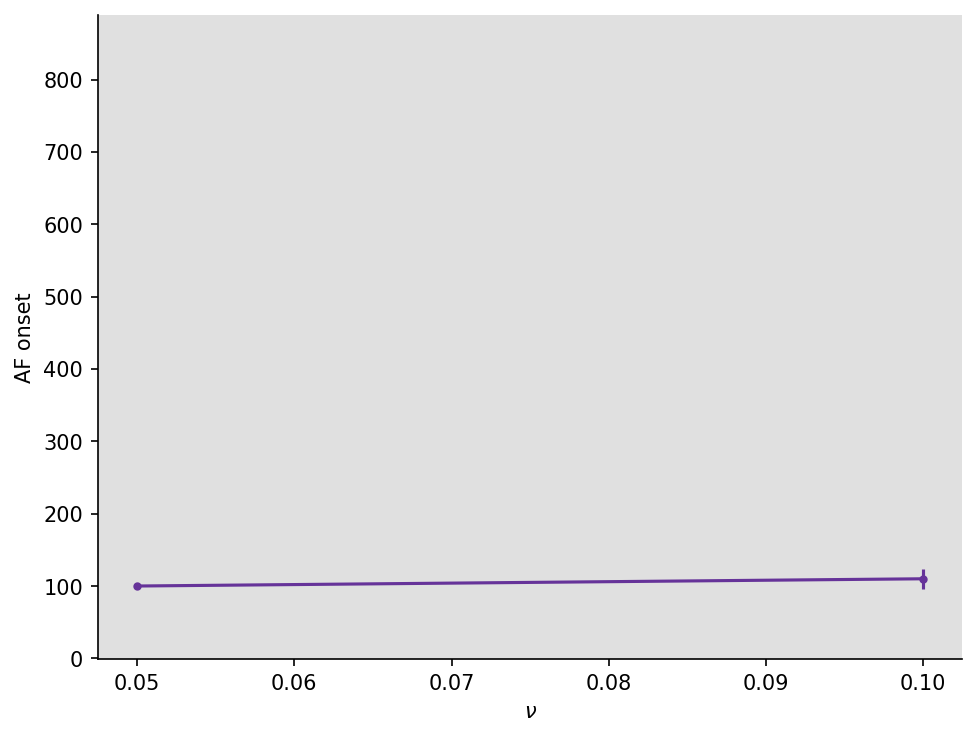

In [162]:
plot_nu_AF_onset(nu_values=[0.05, 0.1])